In [3]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import IPython.display as ipd
import librosa
import librosa.display


from keras.models import model_from_json
from keras.preprocessing import image

In [ ]:
file_json = open('/content/drive/MyDrive/PeriHocaProjeBitisi/utils/model.json', 'r')
loadedjsonmodel = file_json.read()
file_json.close()
modelloaded = model_from_json(loadedjsonmodel)
a = modelloaded.load_weights("/content/drive/MyDrive/PeriHocaProjeBitisi/Trained_Models/Speech_Emotion_Recognition_Model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
audiopath = '/content/drive/MyDrive/PeriHocaProjeBitisi/demo_audio/demo_audio_7.wav'
ipd.Audio(audiopath)

In [ ]:
samples, samplerate = librosa.load(audiopath)
print(samplerate, samples)

22050 [0.00121744 0.00309936 0.00424275 ... 0.00945524 0.00727384 0.00551259]


In [ ]:
def get_audio_features(audio_path,sampling_rate):
    X, samplerate = librosa.load(audio_path ,res_type='kaiser_fast',duration=2.5,sr=sampling_rate*2,offset=0.5)
    samplerate = np.array(samplerate)

    y_harmonic, y_percussive = librosa.effects.hpss(X)
    pitches, magnitudes = librosa.core.pitch.piptrack(y=X, sr=samplerate)

    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=samplerate,n_mfcc=13),axis=1)

    pitches = np.trim_zeros(np.mean(pitches,axis=1))[:20]

    magnitudes = np.trim_zeros(np.mean(magnitudes,axis=1))[:20]

    C = np.mean(librosa.feature.chroma_cqt(y=y_harmonic, sr=sampling_rate),axis=1)

    return [mfccs, pitches, magnitudes, C]


def get_features_dataframe(dataframe, sampling_rate):
    labels = pd.DataFrame(dataframe['label'])

    features  = pd.DataFrame(columns=['mfcc','pitches','magnitudes','C'])
    for index, audio_path in enumerate(dataframe['path']):
        features.loc[index] = get_audio_features(audio_path, sampling_rate)

    mfcc = features.mfcc.apply(pd.Series)
    pit = features.pitches.apply(pd.Series)
    mag = features.magnitudes.apply(pd.Series)
    C = features.C.apply(pd.Series)

    combined_features = pd.concat([mfcc,pit,mag,C],axis=1,ignore_index=True)

    return combined_features, labels

In [ ]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(audiopath,20000)

In [ ]:
mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)
demo_audio_features = pd.concat([mfcc,pit,mag,C],ignore_index=True)

In [ ]:
demo_audio_features= np.expand_dims(demo_audio_features, axis=0)
demo_audio_features= np.expand_dims(demo_audio_features, axis=2)

In [ ]:
demo_audio_features.shape

(1, 65, 1)

In [ ]:
livepreds = modelloaded.predict(demo_audio_features, batch_size=32,verbose=1)

1/1 [==============================] - 0s 326ms/step


In [ ]:
livepreds

array([[9.5877862e-01, 1.0460813e-03, 4.1400217e-03, 2.7666252e-02,
        1.0638458e-06, 1.7103291e-06, 8.3664116e-03]], dtype=float32)

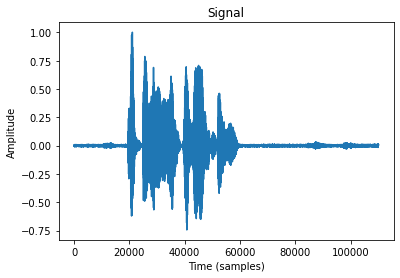

In [ ]:
plt.plot(samples);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

Text(0.5, 1.0, 'Pitches (pit)')

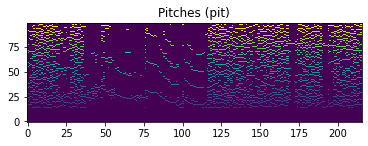

In [ ]:
pitches, magnitudes = librosa.piptrack(y=samples, sr=samplerate)
plt.subplot(212)
plt.imshow(pitches[:100, :], aspect="auto", interpolation="nearest", origin="bottom")
plt.title('Pitches (pit)')

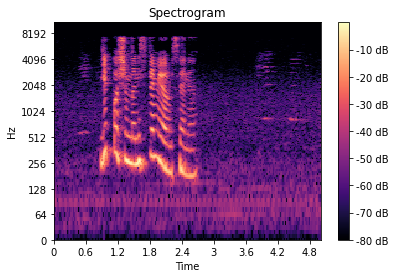

In [ ]:
Spectrogram = np.abs(librosa.stft(samples, hop_length=512))
Spectrogram = librosa.amplitude_to_db(Spectrogram, ref=np.max)
librosa.display.specshow(Spectrogram, sr=samplerate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

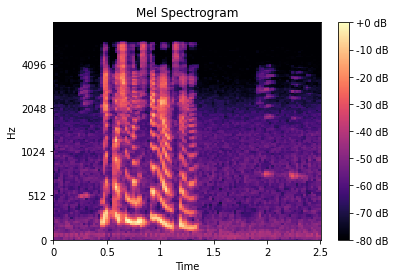

In [ ]:
mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=samplerate, n_fft=2048, hop_length=1024)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
librosa.display.specshow(mel_spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

(20, 216)


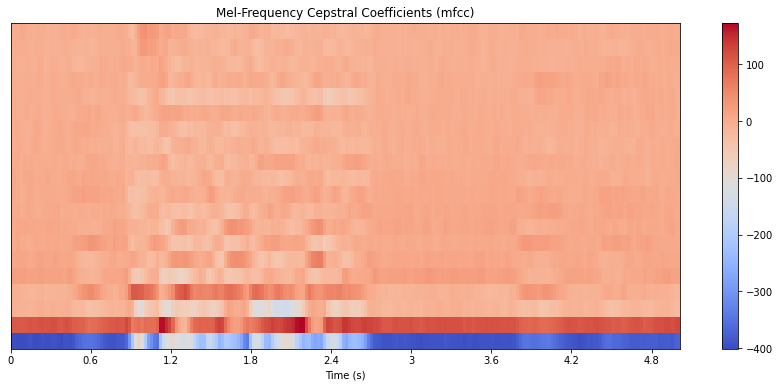

In [ ]:
melfrekepkat=librosa.feature.mfcc(samples,sr=samplerate)
print(melfrekepkat.shape)
plt.figure(figsize=(15,6))
librosa.display.specshow(melfrekepkat,x_axis="s")
plt.title('Mel-Frequency Cepstral Coefficients (mfcc)');
plt.colorbar()

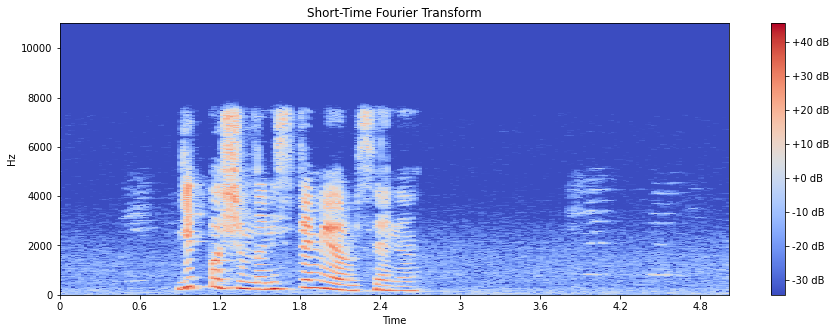

In [ ]:
hop_length = 512
n_fft = 2048
X = librosa.stft(samples, n_fft=n_fft, hop_length=hop_length)
S = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=samplerate, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title('Short-Time Fourier Transform');

plt.colorbar(format='%+2.0f dB')

11895


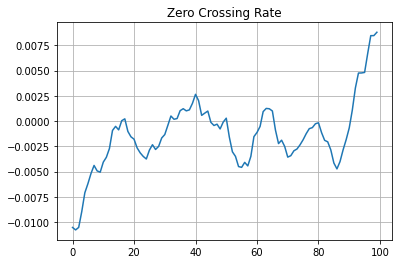

In [ ]:
zero_crossing=librosa.zero_crossings(samples)
print(sum(zero_crossing))
plt.plot(samples[5000:5100])
plt.grid()
plt.title('Zero Crossing Rate');

(1, 216)


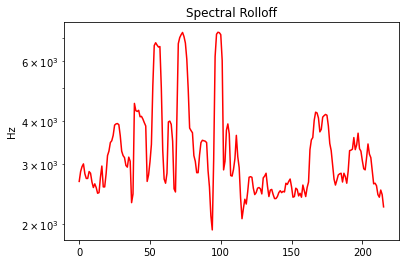

In [ ]:
spec_roll=librosa.feature.spectral_rolloff(samples,sr=samplerate)
print(spec_roll.shape)
plt.semilogy(spec_roll.T,"r")
plt.ylabel("Hz")
plt.title('Spectral Rolloff');

(12, 216)


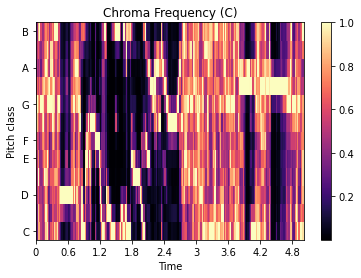

In [ ]:
chroma=librosa.feature.chroma_stft(samples,sr=samplerate)
print(chroma.shape)
librosa.display.specshow(chroma,y_axis="chroma",x_axis="time")
plt.colorbar()
plt.title('Chroma Frequency (C)');

In [ ]:
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
index = livepreds.argmax(axis=1).item()
emotions[index]

'anger'

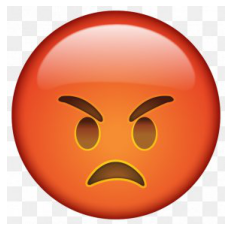

In [ ]:
emojis_img = image.load_img('/content/drive/MyDrive/PeriHocaProjeBitisi/EmotionPic/%s.png'% emotions[index])
plt.imshow(emojis_img)
plt.axis('off')
plt.show()